In [199]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
import numpy as np

sns.set()
plt.rcParams['figure.figsize'] = [15, 10]

In [200]:
# Read data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## Onehot Encoder
The industry feature is categorical feature which cannot be directly used for modelling. So I used onehotencoder to transform the data for modelling purpose.

In [201]:
# Feature engineering
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(pd.DataFrame(train.INDUSTRY))
indu = ["indus_"+i[3:] for i in enc.get_feature_names().tolist()]
train[indu] = pd.DataFrame(enc.transform(pd.DataFrame(train.INDUSTRY)).toarray())
train = train.drop(["INDUSTRY"], axis=1)

test[indu] = pd.DataFrame(enc.transform(pd.DataFrame(test.INDUSTRY)).toarray())
test = test.drop(["INDUSTRY","Unnamed: 0"], axis=1)

In [202]:
test.describe()

,SUBSCRIPTION_FEE,JOB_ACTIVITY_2,JOB_ACTIVITY_3,JOB_ACTIVITY_4,JOB_ACTIVITY_1,JOB_ACTIVITY_5,PAYMENT_TYPE_1,PAYMENT_TYPE_2,PAYMENT_TYPE_3,PAYMENT_TYPE_4,PAYMENT_TYPE_5,indus_A,indus_B,indus_C,indus_D,indus_E,indus_F
count,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1.220000e+03,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000
mean,54.349180,24.131148,48.447541,36.348361,60.718852,18.971311,2.372257e+04,4546.193549,1054.708910,905.713189,13672.016352,0.147541,0.323770,0.194262,0.045902,0.209016,0.079508
std,67.764414,48.170577,72.608232,60.302008,111.772565,34.389364,4.971214e+04,9627.940444,4737.686506,4507.576547,37678.574475,0.354790,0.468106,0.395794,0.209358,0.406773,0.270641
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,0.000000,5.000000,2.000000,4.000000,0.000000,5.881350e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,46.000000,4.500000,25.000000,18.000000,27.000000,6.000000,8.403125e+03,550.000000,0.000000,0.000000,3466.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,52.000000,28.000000,61.000000,44.000000,69.250000,23.000000,2.804192e+04,4513.612500,0.000000,563.287500,14233.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,796.000000,558.000000,829.000000,650.000000,1377.000000,462.000000,1.038283e+06,97400.230000,52559.000000,133112.730000,992692.740000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Downsample
The sample is imbalanced. The B type company have 2 times sample than A or C. So I downsampled the sample to make it even. Compared with the model based on original dataset, this method improved the model performance.

In [203]:
# Downsample to make it balanced
downsampled = resample(train[train.COMPANY_SIZE == "B"], 
                                 replace=False,    # sample without replacement
                                 n_samples=700)
df_downsampled = pd.concat([downsampled, train[train.COMPANY_SIZE != "B"]])

In [204]:
df_downsampled.COMPANY_SIZE.value_counts()

df_downsampled = df_downsampled[df_downsampled.COMPANY_SIZE != "A"]

In [205]:
df_downsampled.COMPANY_SIZE.value_counts()

B    700
C    641
Name: COMPANY_SIZE, dtype: int64

## Train model
Split the dataset tot training and validating set to tune the parameter with the measure of model performance on validating set.

In [206]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import time

le = preprocessing.LabelEncoder()

y = df_downsampled.COMPANY_SIZE
X = df_downsampled.drop(["COMPANY_SIZE"], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

In [207]:
X_train.shape

(898, 17)

In [208]:
X_val.shape

(443, 17)

## GridSearching
### Sklearn 

In [209]:
# Grid search with Random Forest
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

# Time stemp
start_time = time.time()

# Random Forest __ sklearn
parameters = {'max_depth':[5,8,10,12,15], 'n_estimators':[50, 80, 100, 150]}
rf         = RandomForestClassifier()
clf        = GridSearchCV(rf, parameters, scoring='roc_auc',
                          cv=5, n_jobs=-1).fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

# Predict
pred_y_0 = clf.predict(X_val)
pred_y_1 = clf.predict_proba((X_val))
print(classification_report(y_val, pred_y_0))
print(clf.best_params_)

# Calculate AUC
fpr, tpr, thresholds = metrics.roc_curve(y_val, [i[1] for i in pred_y_1])
metrics.auc(fpr, tpr)

--- 9.051409721374512 seconds ---
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       234
           1       0.79      0.72      0.76       209

   micro avg       0.78      0.78      0.78       443
   macro avg       0.78      0.78      0.78       443
weighted avg       0.78      0.78      0.78       443

{'max_depth': 5, 'n_estimators': 100}


0.8541078804236699

In [210]:
# Default threshold = 0.5
prediction = pd.DataFrame(pred_y_0, columns=["predict"])
prediction["p1"] = [i[1] for i in pred_y_1]

print(prediction.groupby("predict").max())
print(prediction.groupby("predict").min())

               p1
predict          
0        0.495125
1        0.885456
               p1
predict          
0        0.004705
1        0.509186


In [211]:
# Confusion matrix
confusion_matrix(y_val, pred_y_0)

array([[194,  40],
       [ 58, 151]])

In [212]:
# Random Forest 
start_time = time.time()
rf         = RandomForestClassifier(max_depth=10, n_estimators=150)
rf.fit(X_train, y_train)
pred_y_0   = rf.predict(X_val)
pred_y_1 = clf.predict_proba((X_val))
print("--- %s seconds ---" % (time.time() - start_time))
print(classification_report(y_val, pred_y_0))
fpr, tpr, thresholds = metrics.roc_curve(y_val, [i[1] for i in pred_y_1])

print(metrics.auc(fpr, tpr))

print(confusion_matrix(y_val, [1 if i[1] > 0.55 else 0 for i in pred_y_1]))

--- 0.4541208744049072 seconds ---
              precision    recall  f1-score   support

           0       0.77      0.82      0.80       234
           1       0.79      0.72      0.75       209

   micro avg       0.78      0.78      0.78       443
   macro avg       0.78      0.77      0.77       443
weighted avg       0.78      0.78      0.78       443

0.8541078804236699
[[196  38]
 [ 63 146]]


### H2O in Python

In [213]:
import h2o
h2o.init(nthreads=-1)             #specify max number of bytes. uses all cores by default.
h2o.remove_all()                          #clean slate, in case cluster was already running

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,1 hour 24 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,6 days
H2O cluster name:,H2O_from_python_gaozhiping_cefn0e
H2O cluster total nodes:,1
H2O cluster free memory:,1.582 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [214]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.frame import H2OFrame

In [215]:
# Feature transformation
x = list(X_train.columns)
y = 'COMPANY_SIZE'
train = X_train.copy()
train['COMPANY_SIZE'] = y_train
train = H2OFrame(train)
train['COMPANY_SIZE'] = train['COMPANY_SIZE'].asfactor()

valid = X_val.copy()
valid['COMPANY_SIZE'] = y_val
valid = H2OFrame(valid)
valid['COMPANY_SIZE'] = valid['COMPANY_SIZE'].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [216]:
# H2O GridSearch with Random Forest
start_time = time.time()
gbm_params1 = {'ntrees': [50, 80, 100, 150],
                'max_depth': [5,8,10,12,15]}



gbm_grid1 = H2OGridSearch(model=H2ORandomForestEstimator,
                          grid_id='gbm_grid1',
                          hyper_params=gbm_params1)
gbm_grid1.train(x=x, y=y,
                training_frame=train,
                seed=1)

# Get the grid results, sorted by validation AUC
gbm_gridperf1 = gbm_grid1.get_grid(sort_by='auc', decreasing=True)
print("--- %s seconds ---" % (time.time() - start_time))
gbm_gridperf1

# Grab the top GBM model, chosen by validation AUC
best_gbm1 = gbm_gridperf1.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_gbm_perf1 = best_gbm1.model_performance(valid)

best_gbm_perf1.auc()

drf Grid Build progress: |████████████████████████████████████████████████| 100%
--- 12.93783187866211 seconds ---


0.8465832413200834

In [217]:
# Check the model with the best performance
gbm_gridperf1

     max_depth ntrees           model_ids                 auc
0           10    150  gbm_grid1_model_18  0.8649086989349865
1           10    100  gbm_grid1_model_13  0.8641163964393579
2            8    150  gbm_grid1_model_17  0.8633365124781435
3            8    100  gbm_grid1_model_12  0.8632669686854236
4           10     80   gbm_grid1_model_8  0.8629937609283104
5           12    150  gbm_grid1_model_19  0.8626286560165315
6            8     80   gbm_grid1_model_7  0.8622089095533302
7           15    150  gbm_grid1_model_20  0.8616028850739151
8           12    100  gbm_grid1_model_14  0.8609447027499603
9           12     80   gbm_grid1_model_9  0.8608850937847718
10          15     80  gbm_grid1_model_10  0.8607162017167382
11           5    150  gbm_grid1_model_16  0.8606665275790812
12          15    100  gbm_grid1_model_15  0.8603883524082022
13           5    100  gbm_grid1_model_11  0.8582076577650612
14           5     80   gbm_grid1_model_6  0.8556941463996185
15      

In [218]:
# Confusion matrix
best_gbm_perf1.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37535734097162887: 


,0,1,Error,Rate
0,170.0,64.0,0.2735,(64.0/234.0)
1,41.0,168.0,0.1962,(41.0/209.0)
Total,211.0,232.0,0.237,(105.0/443.0)


In [219]:
# H2O Random Forest
start_time = time.time()
my_rf = H2ORandomForestEstimator(ntrees = 100, max_depth=5)
#my_rf = H2ORandomForestEstimator(ntrees = 150, max_depth=10, nfolds=5)
my_rf.train(x=x, y=y, training_frame=train)
print("--- %s seconds ---" % (time.time() - start_time))
print("Trainset AUC is %s" % my_rf.model_performance().auc())
print("AUC is %s" % my_rf.model_performance(valid).auc())
my_rf.model_performance(valid).confusion_matrix()

drf Model Build progress: |███████████████████████████████████████████████| 100%
--- 0.9379830360412598 seconds ---
Trainset AUC is 0.8610837903353998
AUC is 0.8529321555637345
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34602851320058103: 


,0,1,Error,Rate
0,122.0,112.0,0.4786,(112.0/234.0)
1,13.0,196.0,0.0622,(13.0/209.0)
Total,135.0,308.0,0.2822,(125.0/443.0)


In [220]:
# AUC with sklearn metrics on H2o prediction
pred = my_rf.predict(H2OFrame(X_val)).as_data_frame()
fpr, tpr, thresholds = metrics.roc_curve(y_val, pred['p1'])
print("AUC by sklearn.metrics is %s" % metrics.auc(fpr, tpr))
confusion_matrix(y_val, pred['predict'])

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
AUC by sklearn.metrics is 0.8529321555637345


array([[184,  50],
       [ 53, 156]])

In [221]:
pred["threshold"] = pred.p1 >= 0.48381023968259496

In [222]:
confusion_matrix(y_val, pred['threshold'])

array([[188,  46],
       [ 56, 153]])

In [223]:
confusion_matrix(y_val, pred['predict'])

array([[184,  50],
       [ 53, 156]])

### Compare the moedel performance

In [ ]:
Prediction_rand = []
Time_rand = []
Prediction_h2o = []
Time_h2o = []
for _ in range(50):
    
    # Time stemp
    start_time = time.time()
    
    # Random Forest __ sklearn
    parameters = {'max_depth':[5,8,10,12,15], 'n_estimators':[50, 80, 100, 150]}
    rf         = RandomForestClassifier()
    clf        = GridSearchCV(rf, parameters, scoring='roc_auc',
                              cv=5, n_jobs=-1).fit(X_train, y_train)
    
    Time_rand.append(time.time() - start_time)
    
    # Predict
    pred_y_0 = clf.predict(X_val)
    pred_y_1 = clf.predict_proba((X_val))

    
    # Calculate AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_val, [i[1] for i in pred_y_1])
    Prediction_rand.append(metrics.auc(fpr, tpr))
    
    
    # H2O GridSearch with Random Forest
    start_time = time.time()
    gbm_params1 = {'ntrees': [50, 80, 100, 150],
                    'max_depth': [5,8,10,12,15]}
    
    
    
    gbm_grid1 = H2OGridSearch(model=H2ORandomForestEstimator,
                              grid_id='gbm_grid1',
                              hyper_params=gbm_params1)
    gbm_grid1.train(x=x, y=y,
                    training_frame=train,
                    seed=1)
    
    # Get the grid results, sorted by validation AUC
    gbm_gridperf1 = gbm_grid1.get_grid(sort_by='auc', decreasing=True)
    Time_h2o.append(time.time() - start_time)
    gbm_gridperf1
    
    # Grab the top GBM model, chosen by validation AUC
    best_gbm1 = gbm_gridperf1.models[0]
    
# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
    best_gbm_perf1 = best_gbm1.model_performance(valid)

    Prediction_h2o.append(best_gbm_perf1.auc())
    
Performance = pd.DataFrame({"Prediction_rand":Prediction_rand, "Prediction_h2o":Prediction_h2o,
                           "Time_rand":Time_rand, "Time_h2o":Time_h2o})
print("All Down")

In [124]:
Performance.head()

,Prediction_rand,Prediction_h2o,Time_rand,Time_h2o
0,0.853529,0.852712,9.281737,12.098605
1,0.868729,0.871670,5.849407,10.266464
2,0.825380,0.830771,5.095633,12.106715
3,0.863434,0.859524,8.735538,14.241034
4,0.875709,0.866625,10.980673,16.647982


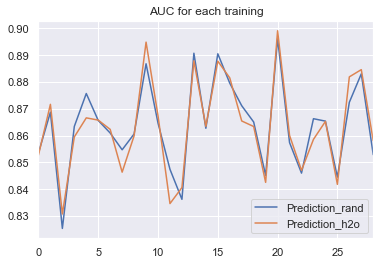

In [125]:
Performance.Prediction_rand.plot()
Performance.Prediction_h2o.plot()
plt.title("AUC for each training")
plt.legend()
plt.show()

In [131]:
Performance[Performance.Prediction_rand < Performance.Prediction_h2o].count()/Performance.count()

Prediction_rand    0.517241
Prediction_h2o     0.517241
Time_rand          0.517241
Time_h2o           0.517241
dtype: float64

### Compare the moedel performance with sampling

In [120]:
h2o.init(nthreads=-1) 
Prediction_rand = []
Time_rand = []
Prediction_h2o = []
Time_h2o = []
for _ in range(30):
    # Downsample to make it balanced
    downsampled = resample(train[train.COMPANY_SIZE == "B"], 
                                 replace=False,    # sample without replacement
                                 n_samples=700)
    df_downsampled = pd.concat([downsampled, train[train.COMPANY_SIZE != "B"]])
    df_downsampled = df_downsampled[df_downsampled.COMPANY_SIZE != "A"]
    
    y = df_downsampled.COMPANY_SIZE
    X = df_downsampled.drop(["COMPANY_SIZE"], axis=1)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)
    
    # Grid search with Random Forest
    y_train = le.fit_transform(y_train)
    y_val = le.transform(y_val)
    
    # Time stemp
    start_time = time.time()
    
    # Random Forest __ sklearn
    parameters = {'max_depth':[5,8,10,12,15], 'n_estimators':[50, 80, 100, 150]}
    rf         = RandomForestClassifier()
    clf        = GridSearchCV(rf, parameters, scoring='roc_auc',
                              cv=5, n_jobs=-1).fit(X_train, y_train)
    
    Time_rand.append(time.time() - start_time)
    
    # Predict
    pred_y_0 = clf.predict(X_val)
    pred_y_1 = clf.predict_proba((X_val))

    
    # Calculate AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_val, [i[1] for i in pred_y_1])
    Prediction_rand.append(metrics.auc(fpr, tpr))
    
    
    # H2O GridSearch with Random Forest
    # h2o.init(nthreads=-1)             #specify max number of bytes. uses all cores by default.
    h2o.remove_all()  
    
    # Feature transformation
    x = list(X_train.columns)
    y = 'COMPANY_SIZE'
    train_h = X_train.copy()
    train_h['COMPANY_SIZE'] = y_train
    train_h = H2OFrame(train_h)
    train_h['COMPANY_SIZE'] = train_h['COMPANY_SIZE'].asfactor()
    
    valid_h = X_val.copy()
    valid_h['COMPANY_SIZE'] = y_val
    valid_h = H2OFrame(valid_h)
    valid_h['COMPANY_SIZE'] = valid_h['COMPANY_SIZE'].asfactor()
    
    start_time = time.time()
    gbm_params1 = {'ntrees': [50, 80, 100, 150],
                    'max_depth': [5,8,10,12,15]}
    
    
    
    gbm_grid1 = H2OGridSearch(model=H2ORandomForestEstimator,
                              grid_id='gbm_grid1',
                              hyper_params=gbm_params1)
    gbm_grid1.train(x=x, y=y,
                    training_frame=train_h,
                    seed=1)
    
    # Get the grid results, sorted by validation AUC
    gbm_gridperf1 = gbm_grid1.get_grid(sort_by='auc', decreasing=True)
    Time_h2o.append(time.time() - start_time)
    gbm_gridperf1
    
    # Grab the top GBM model, chosen by validation AUC
    best_gbm1 = gbm_gridperf1.models[0]
    
# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
    best_gbm_perf1 = best_gbm1.model_performance(valid_h)

    Prediction_h2o.append(best_gbm_perf1.auc())
    # h2o.shutdown()

h2o.shutdown()
Performance = pd.DataFrame({"Prediction_rand":Prediction_rand, "Prediction_h2o":Prediction_h2o,
                           "Time_rand":Time_rand, "Time_h2o":Time_h2o})
print("All Down")

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,6 mins 08 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,6 days
H2O cluster name:,H2O_from_python_gaozhiping_cefn0e
H2O cluster total nodes:,1
H2O cluster free memory:,1.756 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Grid Build progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Grid Build progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Grid Build progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Grid Build progress: |████████████████████████████████████████████████| 100%
Parse progress: |███████████

KeyboardInterrupt: 

In [96]:
Performance.head()

,Prediction_rand,Prediction_h2o,Time_rand,Time_h2o
0,0.954833,0.955878,5.986408,12.157410
1,0.953006,0.955878,6.569238,1.546691
2,0.953944,0.955878,5.763797,1.548668
3,0.953751,0.955878,6.237865,3.560598
4,0.954232,0.955878,7.508816,1.681860


In [ ]:
Performance.Prediction_rand.plot()
Performance.Prediction_h2o.plot()
plt.title("AUC for each training")
plt.legend()
plt.show()

### Try AutoML

`exclude_algos` or `include_algos` allows to select targeting algorithms;
`nfolds` for cross_validation(default=5);
`balance_classes` allows you to balance the dataset;
`stopping_metric` is used for early stopping of the grid searches and individual models(Defaults=logloss for classification, deviance for regression);

In [176]:
from h2o.automl import H2OAutoML
h2o.init(nthreads=-1) 
h2o.remove_all() 

# Feature transformation
x = list(X_train.columns)
y = 'COMPANY_SIZE'
train = X_train.copy()
train['COMPANY_SIZE'] = y_train
train = H2OFrame(train)
train['COMPANY_SIZE'] = train['COMPANY_SIZE'].asfactor()

valid = X_val.copy()
valid['COMPANY_SIZE'] = y_val
valid = H2OFrame(valid)
valid['COMPANY_SIZE'] = valid['COMPANY_SIZE'].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=train)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,39 mins 46 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,6 days
H2O cluster name:,H2O_from_python_gaozhiping_cefn0e
H2O cluster total nodes:,1
H2O cluster free memory:,1.587 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


In [177]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20190625_144411,0.855996,0.472002,0.210547,0.3916,0.15335
XGBoost_grid_1_AutoML_20190625_144411_model_3,0.855716,0.472722,0.211694,0.391411,0.153202
StackedEnsemble_AllModels_AutoML_20190625_144411,0.853921,0.475755,0.206427,0.393416,0.154776
XGBoost_3_AutoML_20190625_144411,0.85227,0.47769,0.208269,0.394365,0.155524
XGBoost_1_AutoML_20190625_144411,0.852171,0.474988,0.208333,0.393358,0.154731
XGBoost_2_AutoML_20190625_144411,0.852141,0.479082,0.213407,0.394918,0.15596
XGBoost_grid_1_AutoML_20190625_144411_model_2,0.851342,0.497923,0.232858,0.402775,0.162228
XGBoost_grid_1_AutoML_20190625_144411_model_1,0.850416,0.476063,0.211128,0.394962,0.155995
GBM_1_AutoML_20190625_144411,0.849257,0.491732,0.228544,0.399864,0.159891
GBM_3_AutoML_20190625_144411,0.846248,0.487765,0.241337,0.39879,0.159033


In [178]:
# The leader model is stored here
aml.leader

# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

preds = aml.predict(valid)

# or:
#preds = aml.leader.predict(valid)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [179]:
# AUC with sklearn metrics on H2o prediction
pred = aml.predict(H2OFrame(X_val)).as_data_frame()
fpr, tpr, thresholds = metrics.roc_curve(y_val, pred['p1'])
print("AUC by sklearn.metrics is %s" % metrics.auc(fpr, tpr))
confusion_matrix(y_val, pred['predict'])

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
AUC by sklearn.metrics is 0.8598893215822915


array([[202,  36],
       [ 64, 141]])

In [191]:
h2o.remove_all() 
# Feature transformation
x = list(X_train.columns)
y = 'COMPANY_SIZE'
train = X_train.copy()
train['COMPANY_SIZE'] = y_train
train = H2OFrame(train)
train['COMPANY_SIZE'] = train['COMPANY_SIZE'].asfactor()

valid = X_val.copy()
valid['COMPANY_SIZE'] = y_val
valid = H2OFrame(valid)
valid['COMPANY_SIZE'] = valid['COMPANY_SIZE'].asfactor()

# H2O GridSearch with Random Forest
start_time = time.time()
gbm_params1 = {'ntrees': [50, 80, 100, 150],
                'max_depth': [5,8,10,12,15]}



gbm_grid1 = H2OGridSearch(model=H2ORandomForestEstimator,
                          grid_id='gbm_grid1',
                          hyper_params=gbm_params1)
gbm_grid1.train(x=x, y=y,
                training_frame=train,
                seed=1)

# Get the grid results, sorted by validation AUC
gbm_gridperf1 = gbm_grid1.get_grid(sort_by='auc', decreasing=True)
print("--- %s seconds ---" % (time.time() - start_time))
gbm_gridperf1

# Grab the top GBM model, chosen by validation AUC
best_gbm1 = gbm_gridperf1.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_gbm_perf1 = best_gbm1.model_performance(valid)

best_gbm_perf1.auc()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Grid Build progress: |████████████████████████████████████████████████| 100%
--- 14.13841986656189 seconds ---


0.8602377536380407

In [192]:
# AUC with sklearn metrics on H2o prediction
pred = best_gbm1.predict(H2OFrame(X_val)).as_data_frame()
fpr, tpr, thresholds = metrics.roc_curve(y_val, pred['p1'])
print("AUC by sklearn.metrics is %s" % metrics.auc(fpr, tpr))
confusion_matrix(y_val, pred['predict'])

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
AUC by sklearn.metrics is 0.8602377536380407


array([[203,  35],
       [ 62, 143]])

In [193]:
gbm_gridperf1

     max_depth ntrees           model_ids                 auc
0           15    150  gbm_grid1_model_20  0.8620601493307916
1            8    150  gbm_grid1_model_17  0.8619434846499067
2           12    150  gbm_grid1_model_19  0.8615537749712062
3           10    150  gbm_grid1_model_18  0.8613080344731722
4            8    100  gbm_grid1_model_12  0.8603697525715874
5           15    100  gbm_grid1_model_15   0.860208407800151
6            5    150  gbm_grid1_model_16   0.859600262123198
7           12    100  gbm_grid1_model_14  0.8595183486238532
8           10    100  gbm_grid1_model_13  0.8591385678541642
9            8     80   gbm_grid1_model_7  0.8589474363556932
10          15     80  gbm_grid1_model_10  0.8582946105881886
11          12     80   gbm_grid1_model_9  0.8577584495015688
12          10     80   gbm_grid1_model_8  0.8576070336391437
13           5    100  gbm_grid1_model_11  0.8569964057349378
14           5     80   gbm_grid1_model_6  0.8564925136026054
15      

In [ ]:
h2o.shutdown()